# Identificação

- Discente: Helder Mateus dos Reis Matos
- Matrícula: 202520080003
- Disciplina: Fundamentos de Inteligência Computacional e Ciência de Dados
- Docente: Claudomiro de Souza de Sales Junior
- Tarefa: Atividade 03 - Sample distribution and sampling distribution, TLC and p-value

- Link para o Colab (modo leitura): https://colab.research.google.com/drive/1mHjHPgP7ju4_vOLvvkgrFWJwQXlS9z9b?usp=sharing

# 0. Configurações

In [1]:
!wget -O pso.py https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade02/pso.py

--2025-05-06 01:50:03--  https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade02/pso.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4961 (4.8K) [text/plain]
Saving to: ‘pso.py’

pso.py              100%[===================>]   4.84K  --.-KB/s    in 0s      

2025-05-06 01:50:03 (44.8 MB/s) - ‘pso.py’ saved [4961/4961]



In [2]:
import itertools
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from scipy.stats import norm
import scipy.stats as stats

from pso import Particle, Swarm, ackley, particle_swarm_optimization

# 1. Sample distribution and sampling distribution

*A partir do que foi feito na Atividade 2 “Considerando o primeiro trabalho, defina um experimento em que dados são coletados de uma variável de interesse do seu trabalho”, crie uma população artificial dessa variável com uma distribuição Gaussiana e demonstre sample distribution and sampling distribution. Faça avaliações de probabilidade de possíveis eventos.*

Nesta atividade, a variável de interesse é o tempo de processamento _etime_ para a execução do algoritmo Particle Swarm Optimization (PSO) em execuções sobre a função Ackley bidimensional. Essa variável representa o tempo decorrido entre o início e o fim da chamada da função `particle_swarm_optimization`, que depende diretamente das soluções iniciais encontradas, da dinâmica de atualização das partículas e da topologia de vizinhança adotada, podendo variar significativamente entre execuções devido à natureza estocástica do algoritmo.

O script a seguir cria um DataFrame que detalha as execuções do algoritmo sobre essa função através da melhor posição encontrada _x_ e _y_, o melhor fitness encontrado _z_, o tempo de execução da função _etime_, e um categórico _convergence_ que indica se houve ou não convergência na execução, considerando se a diferença entre o melhor fitness do enxame e o melhor local for da ordem de $10^{-3}$.

In [3]:
n = 1000

runs = []
etime = []

for _ in range(n):
    start_time = time.time()

    run = particle_swarm_optimization(
        cost_function=ackley,
        DIMENSIONS=2, GLOBAL_BEST=0,
        B_LO=-10, B_HI=10,
        POPULATION=20, V_MAX=0.1,
        PERSONAL_C=2.0, SOCIAL_C=2.0,
        CONVERGENCE=0.001, MAX_ITER=100
    )

    end_time = time.time()

    runs.append(run)
    etime.append(end_time - start_time)

data_pso = {
    "x": [r[0][0] for r in runs],
    "y": [r[0][1] for r in runs],
    "z": [r[1] for r in runs],
    "etime": etime,
    "convergence": ["Yes" if r[2] < 100 else "No" for r in runs],
}

df_pso = pd.DataFrame(data_pso)
df_pso

,x,y,z,etime,convergence
0,0.000109,-0.000155,0.000537,0.045069,Yes
1,-0.000015,0.000104,0.000298,0.030449,Yes
2,-0.000172,-0.000209,0.000768,0.042258,Yes
3,0.000250,0.000121,0.000788,0.037183,Yes
4,0.000021,0.000348,0.000990,0.057584,Yes
...,...,...,...,...,...
995,0.000099,-0.000196,0.000621,0.032698,Yes
996,-0.000049,-0.000137,0.000413,0.034055,Yes
997,0.000157,-0.000264,0.000871,0.041186,Yes
998,0.000050,-0.000129,0.000392,0.055703,Yes


## 1.1. Sample distribution

Tomando o atributo _etime_ como a população de tempos de execução, podemos extrair amostras da população e analisar seu comportamento, sendo este o conceito de _sample distribution_. Digamos que queremos analisar uma amostra de 30 tempos de processamento aleatórios da população:

In [4]:
sample = df_pso["etime"].sample(30)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0581
Sample std: 0.0347


Os valores de média e desvio padrão desta amostra aleatória tem uma alta chance de divergirem dos valores calculados para uma segunda amostra de mesmo tamanho:

In [5]:
sample = df_pso["etime"].sample(30)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0575
Sample std: 0.0507


Uma terceira amostra também terá média e desvio padrão diferentes:

In [6]:
sample = df_pso["etime"].sample(30)
sample_mean = sample.mean()
sample_std = sample.std()

print(f"Sample mean: {sample_mean:.4f}")
print(f"Sample std: {sample_std:.4f}")

Sample mean: 0.0617
Sample std: 0.0466


De modo geral, diferentes amostras resultam em diferentes tendências, ou seja, uma única amostra da população não representa o comportamento médio da mesma. É aqui que entra a _sampling distribution_.

## 1.2. Sampling distribution

_Sampling distribution_ utiliza as médias das amostras individuais com _sample distribution_. A variável `sampling` é uma lista das médias de 100 amostras de tempos de execução, e vai se tornar a variável de interesse para a construção de uma nova distribuição.

In [7]:
sampling = [df_pso["etime"].sample(30).mean() for _ in range(100)]
sampling

[np.float64(0.06340671380360921),
 np.float64(0.059883928298950194),
 np.float64(0.05009152889251709),
 np.float64(0.04349203109741211),
 np.float64(0.06688191890716552),
 np.float64(0.06406163374582927),
 np.float64(0.05837642351786296),
 np.float64(0.08436591625213623),
 np.float64(0.07035447756449381),
 np.float64(0.0532040278116862),
 np.float64(0.06226772467295329),
 np.float64(0.06770764191945394),
 np.float64(0.06303026676177978),
 np.float64(0.05501838525136312),
 np.float64(0.07377440929412842),
 np.float64(0.04980365435282389),
 np.float64(0.053177229563395184),
 np.float64(0.0526520570119222),
 np.float64(0.06508278052012126),
 np.float64(0.06528391043345133),
 np.float64(0.05715763568878174),
 np.float64(0.06968491872151693),
 np.float64(0.05359052817026774),
 np.float64(0.05431749820709229),
 np.float64(0.05335082213083903),
 np.float64(0.06087801456451416),
 np.float64(0.06580930550893148),
 np.float64(0.0647519588470459),
 np.float64(0.058896907170613605),
 np.float64(0.

De posse dessas médias, podemos fazer um estudo da distribuição das frequências destas médias e verificar se esta se aproxima de uma função gaussiana. A função `histogram_experiment()` recebe como parâmetro principal as médias extraídas, computa os valores de média da população _mu_ e desvio padrão da população _sigma_, e realiza o ajuste de uma distribuição normal em relação aos valores encontrados de _mu_ e _sigma_. Como podemos ver na Figura abaixo, a curva normal fitada acompanha a distribuição de frequências de um histograma de 10 bins, indicando que a nova distribuição normal pode ser utilizada para extrair novas amostras de população ou como entrada para testes estatísticos que validem a significância estatística da distribuição.

<Axes: title={'center': 'Distribuição de etime'}>

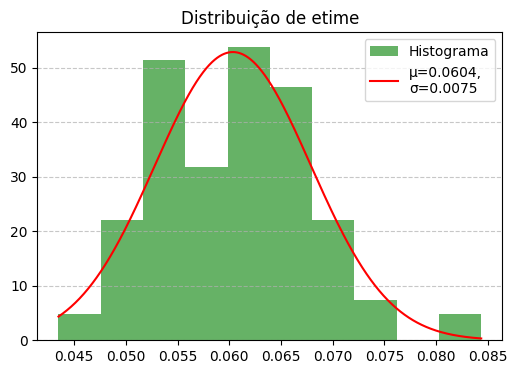

In [8]:
def histogram_experiment(s, title: str, ax: plt.Axes = None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.hist(s, bins=10, density=True, alpha=0.6, color='g', label="Histograma")

    mu, sigma = norm.fit(s)
    x = np.linspace(min(s), max(s), 1000)
    pdf = norm.pdf(x, mu, sigma)

    ax.plot(x, pdf, 'r-', label=f"μ={mu:.4f},\nσ={sigma:.4f}")

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_title(title)

    ax.legend(loc='upper right', fontsize=10)

    return ax

histogram_experiment(sampling, "Distribuição de etime")

# 2. TLC

_Aplique o TLC a função de distribuição gama e avalie quatro diferentes tamanhos de amostra, começando em 10._

O Teorema do Limite Central (TLC) consiste em extrair e analisar estatisticamente uma gaussiana a partir da coleta das tendências centrais de uma distribuição original. Para aplicar o TLC à distribuição gamma, é importante conhecer seus parâmetros:

- _shape_: controla a forma da distribuição, ou seja, a sua assimetria. Quanto maior, mais a curva se aproxima de uma normal.
- _scale_: estica ou comprime a distribuição no eixo horizontal, controlando a dispersão dos valores.

Para os mesmos parâmetros de amostra de 1000 elementos e de tamanho 30 aplicados na função gamma, é possível extrair uma gaussiana com as médias das amostras. Para amostras colhidas de uma função gamma com $shape = 2$ e $scale = 1$, a média e desvio padrão da gaussiana resultante se aproximam de $2$ e $0.2$, respectivamente, como mostra a Figura abaixo:

<Axes: title={'center': 'Frequências de gamma para shape = 2 e scale = 1'}>

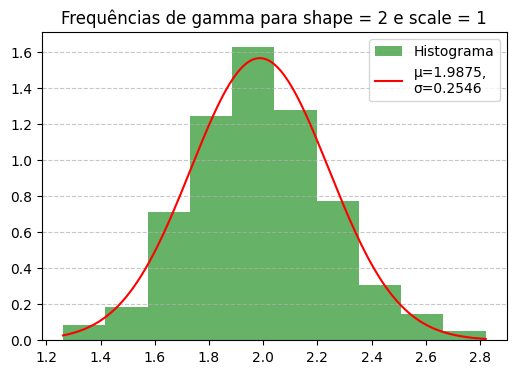

In [9]:
gamma_shape = 2
gamma_scale = 1

n_samples = 1000
sample_size = 30

gamma_means = [np.mean(np.random.gamma(gamma_shape, gamma_scale, sample_size)) for _ in range(n_samples)]

histogram_experiment(gamma_means, f"Frequências de gamma para shape = {gamma_shape} e scale = {gamma_scale}")

Para efeitos de escalabilidade do tamanho das amostras e dos intervalos de parâmetros, a função `histogram_grid()` cria uma grid de dimensão igual a quantidade de valores de _shape_ e _scale_ de interesse. A figura abaixo mostra a aplicação do TLC para as diferentes combinações de valores dos dois parâmetros para um intervalo entre 1 e 3 inclusivos, considerando amostras de tamanho 10. Note que, mesmo diante da variação dos parâmetros da função, as médias tendem a um valor próximo ao denotado na primeira Figura, 2. Entretanto, os valores de desvios padrão aumentaram, chegando a uma ordem de $4 \times 10^{-1}$.

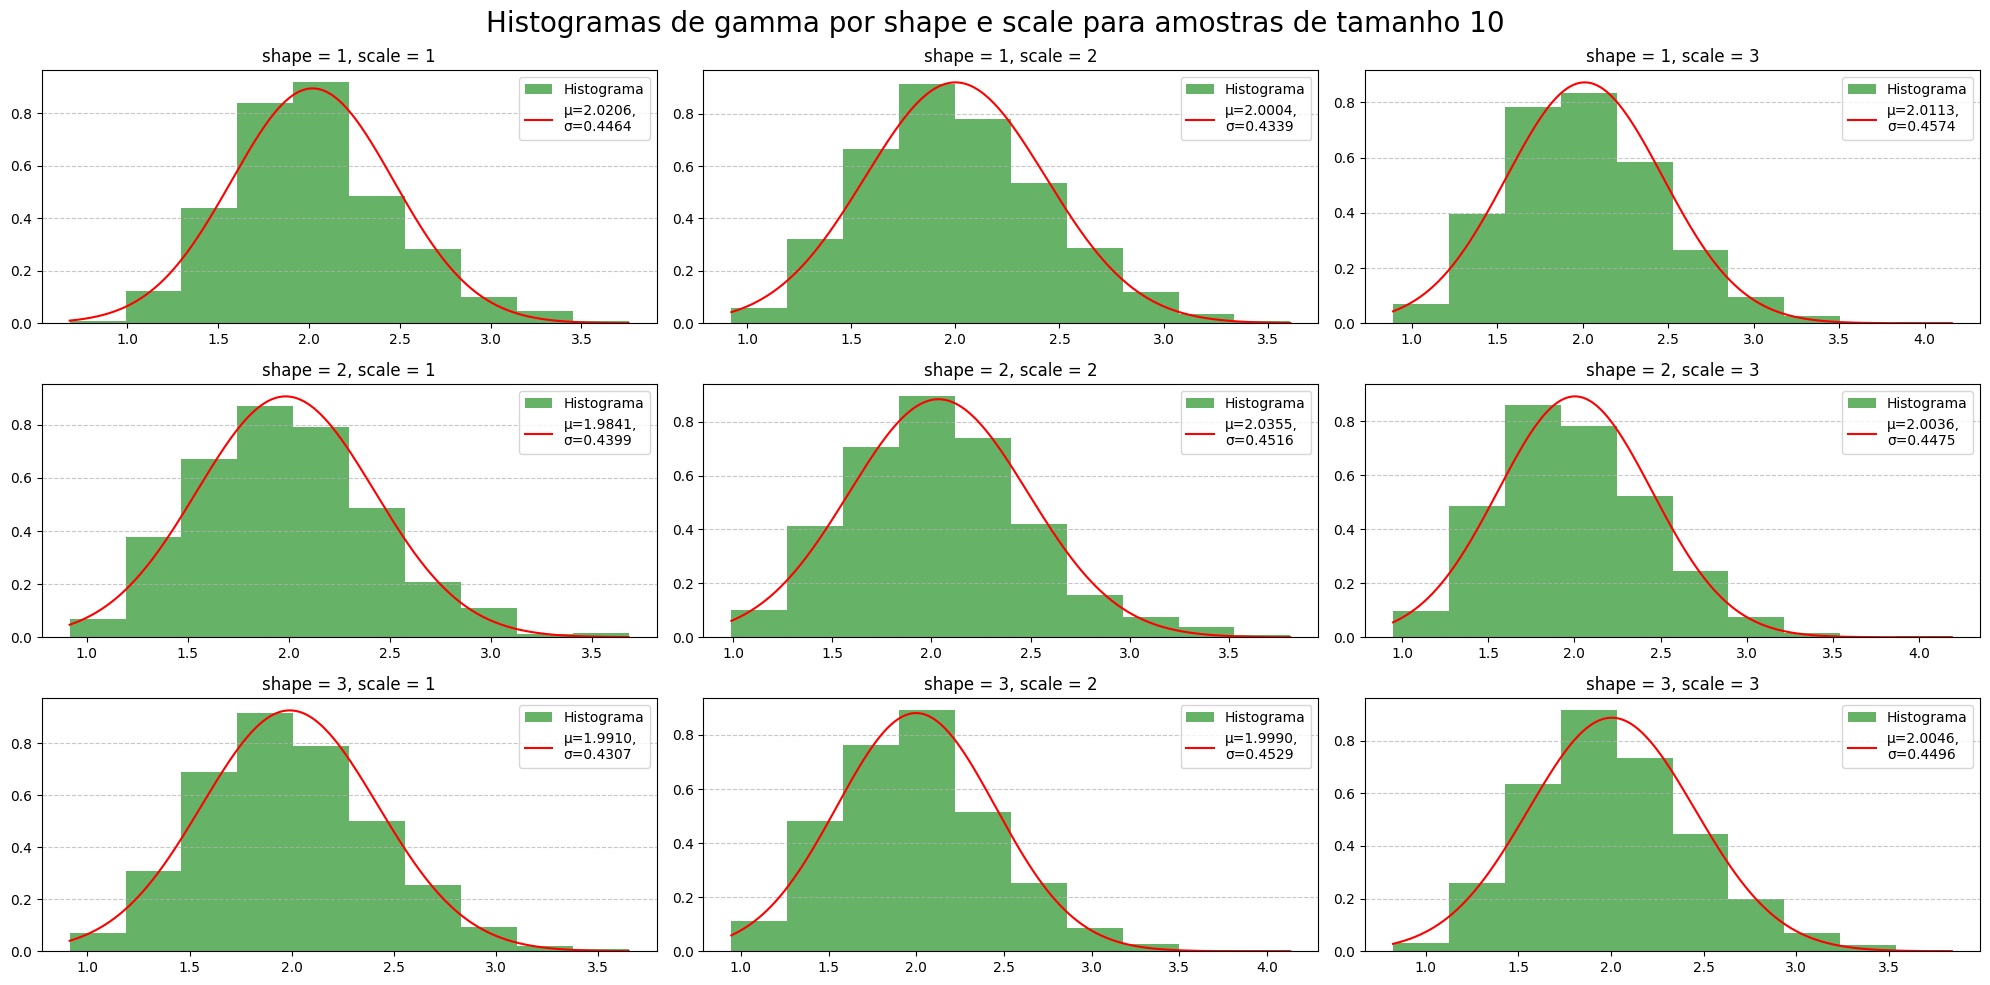

In [10]:
def histogram_grid(min_gshape: int, max_gshape: int, min_gscale: int, max_gscale: int, sample_size: int = 10, n_samples: int = 1000):

    nrows = max_gshape - min_gshape + 1
    ncols = max_gscale - min_gscale + 1

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    gshape = min_gshape
    gscale = min_gscale

    for i, j in itertools.product(range(nrows), range(ncols)):
        gamma_means = [np.mean(np.random.gamma(gamma_shape, gamma_scale, sample_size)) for _ in range(n_samples)]
        histogram_experiment(gamma_means, f"shape = {gshape}, scale = {gscale}", axs[i][j])
        gscale += 1
        if gscale > max_gscale:
            gshape += 1
            gscale = min_gscale

    fig.suptitle(f"Histogramas de gamma por shape e scale para amostras de tamanho {sample_size}", fontsize=20)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.tight_layout()
    return fig, axs

histogram_grid(
    min_gshape=1, max_gshape=3,
    min_gscale=1, max_gscale=3,
    sample_size=10, n_samples=1000
);

Vamos aumentar o tamanho das amostras, agora com 100 elementos cada. A média das gaussianas manteve-se em torno de 2, enquanto que os desvios padrão diminuiram, agora concentrados perto de 0.14. Com mais amostras na população, o grau de incertezas associados à escolha de valores próximos aos extremos da distribuição original diminui, resultando em um intervalo de desvio menor.

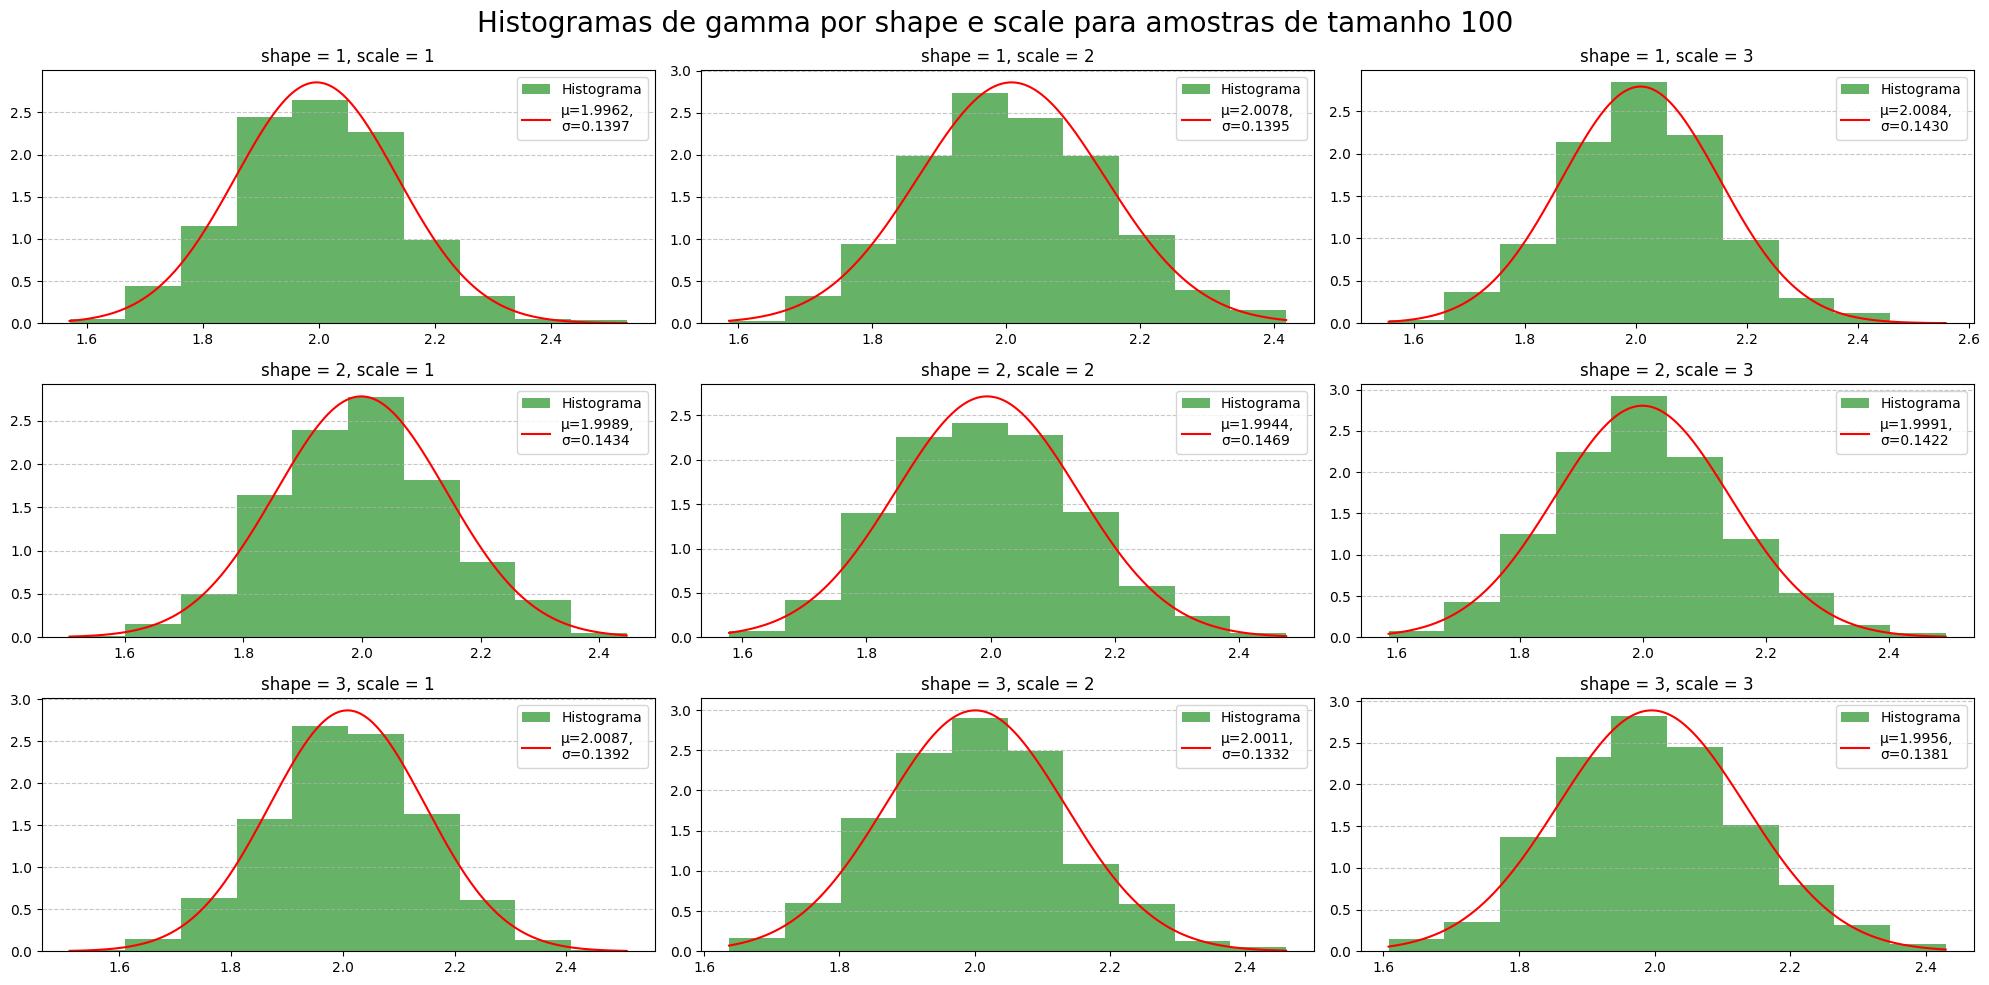

In [11]:
histogram_grid(
    min_gshape=1, max_gshape=3,
    min_gscale=1, max_gscale=3,
    sample_size=100, n_samples=1000
);

Mais uma vez aumentando a escala do tamanho da amostras, desta vez para $10^3$, as médias mantém suas tendências, enquanto que os desvios padrão diminuem.

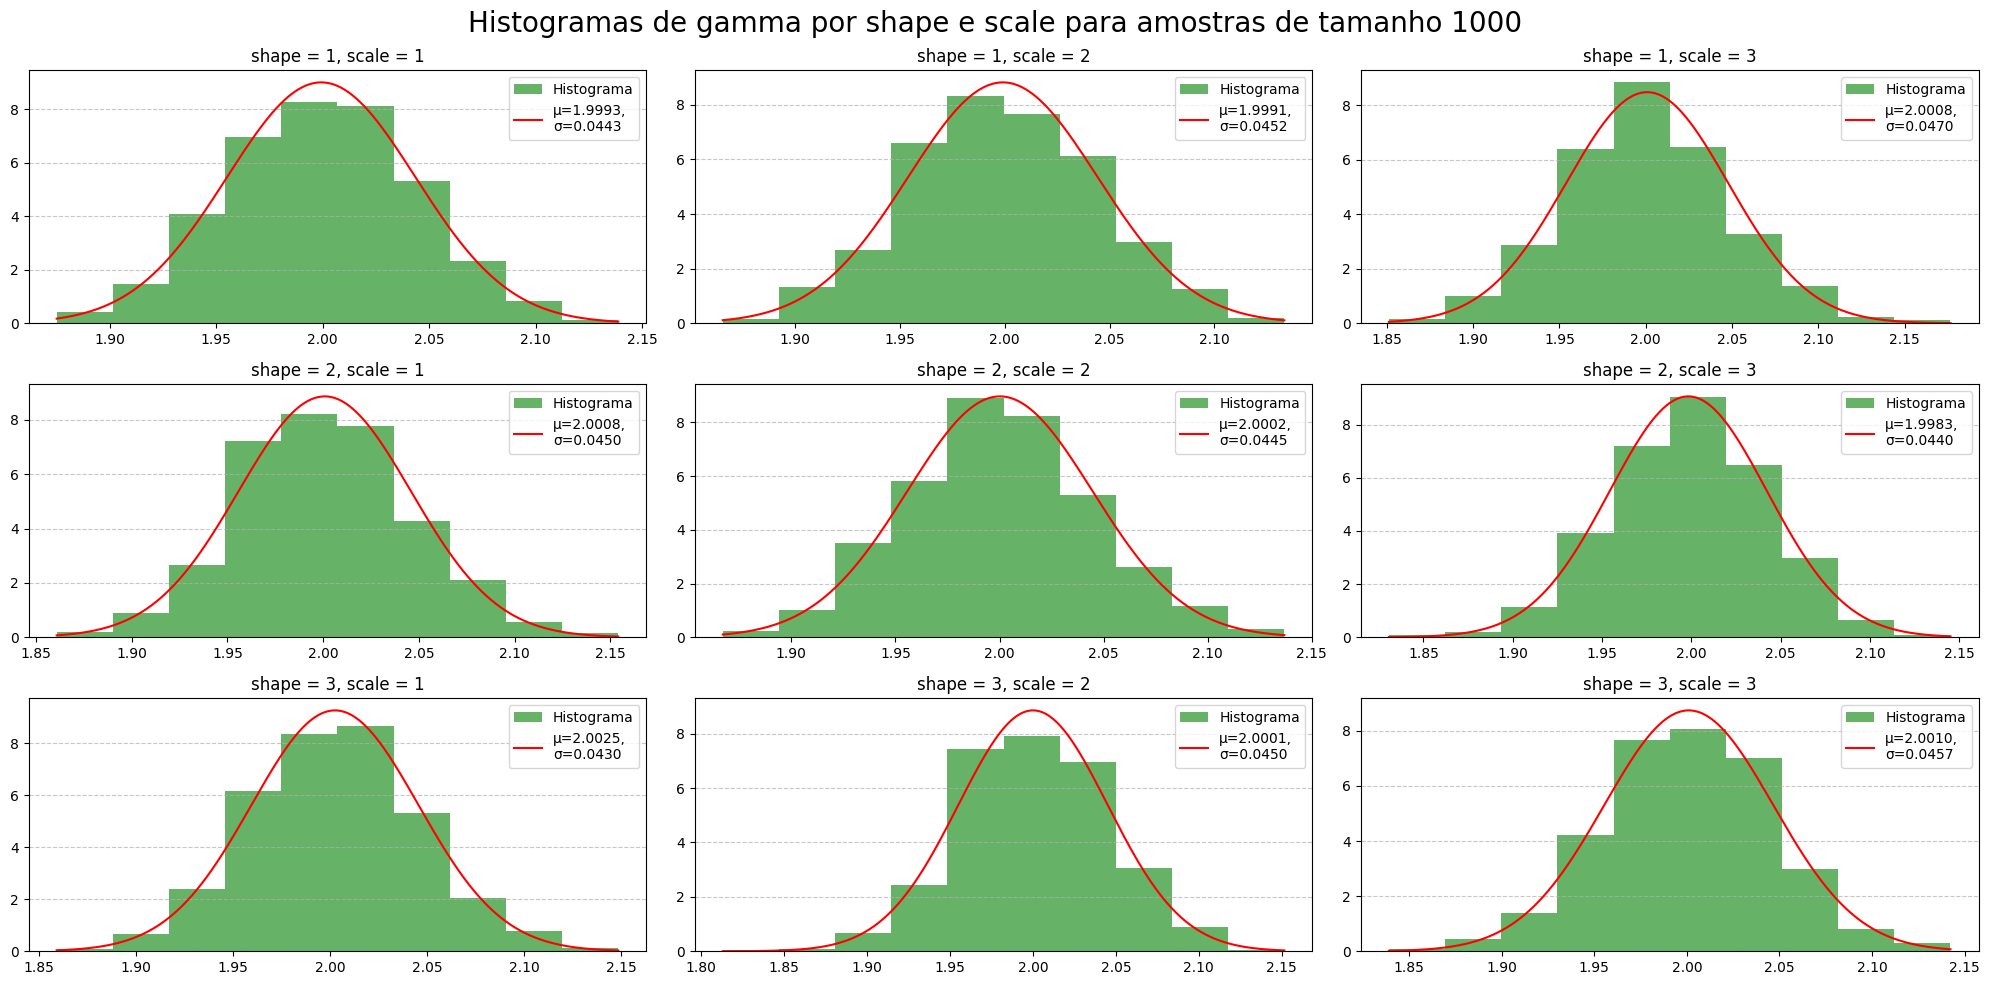

In [12]:
histogram_grid(
    min_gshape=1, max_gshape=3,
    min_gscale=1, max_gscale=3,
    sample_size=1_000, n_samples=1000
);

Indo para escala ainda maiores, como em $10^6$, as observações se mantém. Desta forma, é possível afirmar que, o tamanho da amostra impacta diretamente no grau de certeza de que amostras aleatórias da distribuição original tenha seus valores próximos aos valores mais frequentes da mesma.

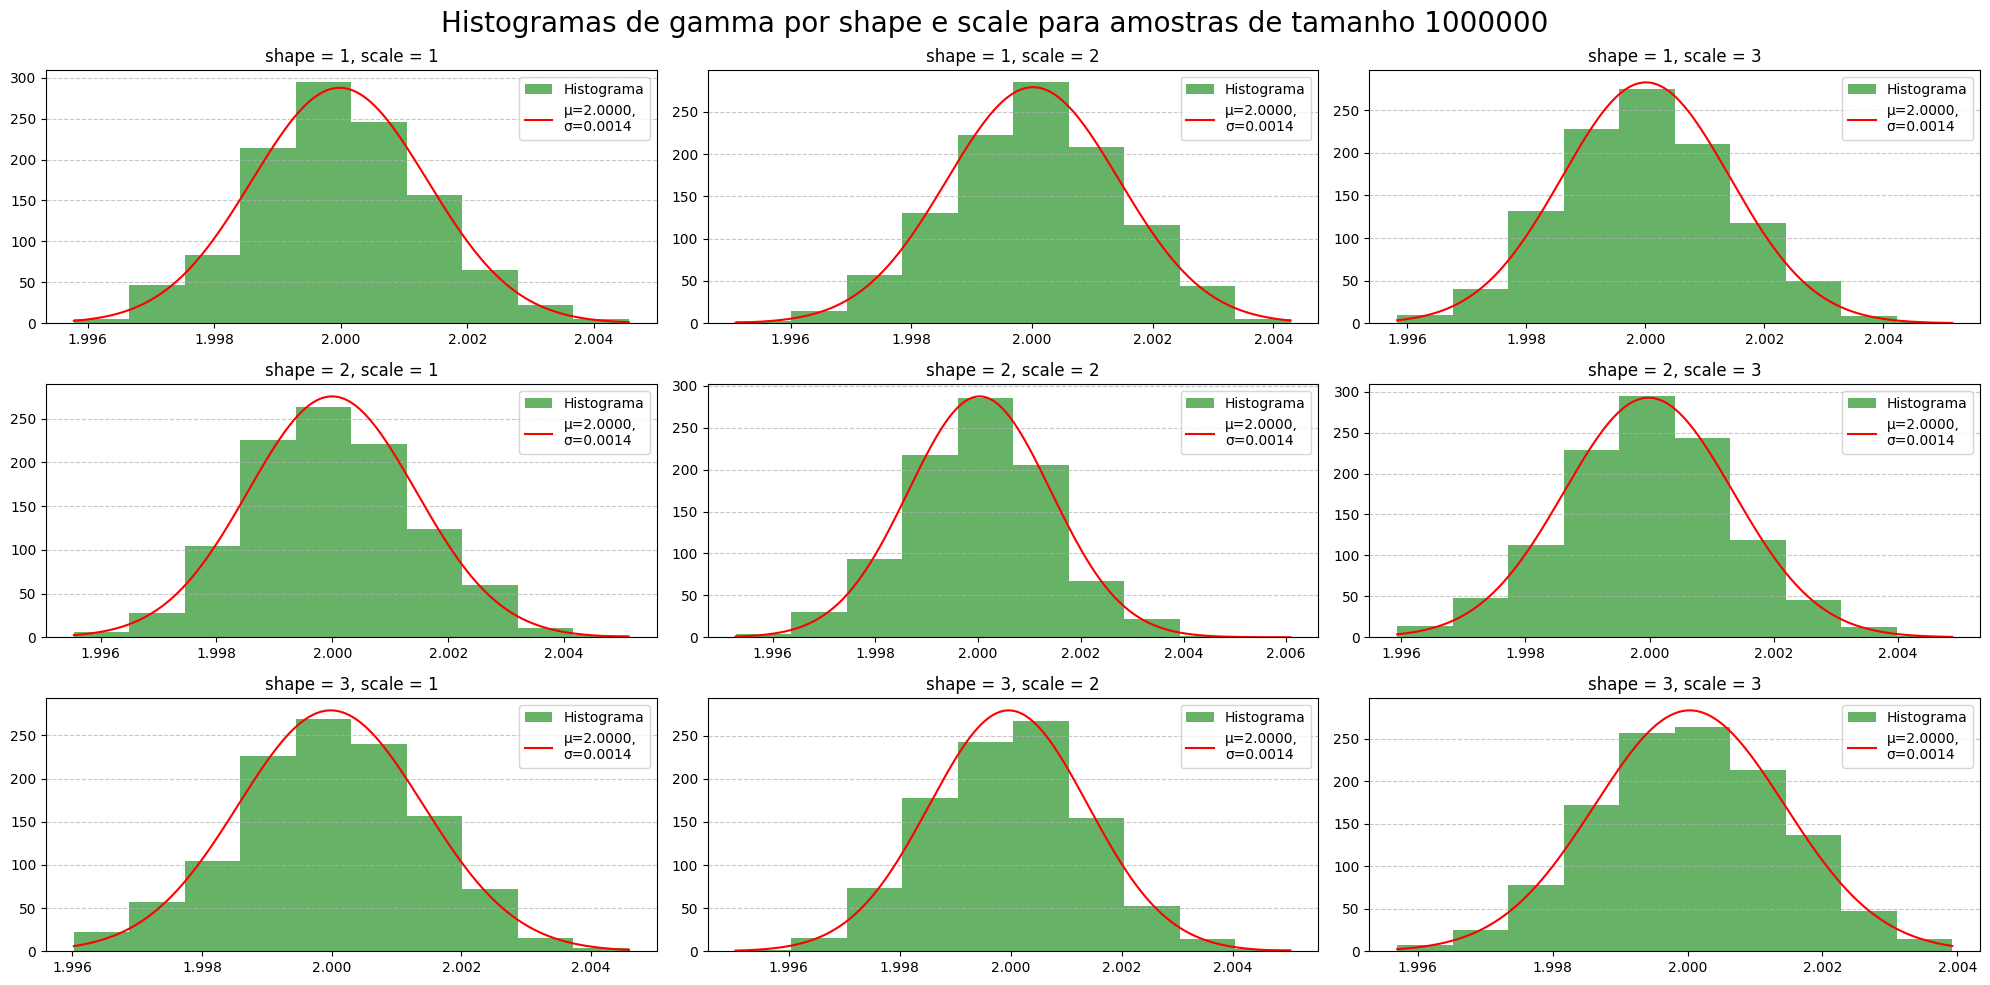

In [13]:
histogram_grid(
    min_gshape=1, max_gshape=3,
    min_gscale=1, max_gscale=3,
    sample_size=1_000_000, n_samples=1000
);

# 3. p-value

_Faça um programa que mostra o passo a passo para calcular o p-value do evento abaixo. Coloque figuras para cada passo._

<p align="center">
  <img src="https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade03/imagens/c.png" alt="Imagem da Atividade 03" width="600">
</p>

O evento pode ser descrito como o lançamento de 5 moedas, em que uma delas resulte em _"tail"_. Podemos levantar a seguinte hipótese nula:

$H_{0}$: as moedas são justas.

Ou seja, espera-se que a probabilidade dos dois possíveis resultados do lançamento de uma moeda sejam de 50%. Assim, podemos calcular o p-value para o evento descrito e, consequentemente, confirmar de que este não pode acontecer por acaso.

A função `all_flip_outcomes()` utiliza uma classe da biblioteca itertools do Python para obter o produto cartesiano das combinações de _heads_ e _tails_ do experimento. Para fins didáticos, vou tratar _heads_ como 🥇 e _tails_ como 🥈. O DataFrame `df_tosses` contém todos os $2^{5} = 32$ possíveis eventos ou cenários alcançáveis ao se jogar 5 moedas.

In [14]:
def all_flip_outcomes(n_coins):
    return np.array(list(itertools.product(["🥇", "🥈"], repeat=n_coins)))

n_coins = 5
outcomes = all_flip_outcomes(n_coins)

df_tosses = pd.DataFrame(outcomes, columns=[f"c{i+1}" for i in range(n_coins)])
df_tosses

,c1,c2,c3,c4,c5
0,🥇,🥇,🥇,🥇,🥇
1,🥇,🥇,🥇,🥇,🥈
2,🥇,🥇,🥇,🥈,🥇
3,🥇,🥇,🥇,🥈,🥈
4,🥇,🥇,🥈,🥇,🥇
5,🥇,🥇,🥈,🥇,🥈
6,🥇,🥇,🥈,🥈,🥇
7,🥇,🥇,🥈,🥈,🥈
8,🥇,🥈,🥇,🥇,🥇
9,🥇,🥈,🥇,🥇,🥈


O p-value do evento que queremos calcular é composto pela soma de 3 parcelas:

- Probabilidade da observação.
- Probabilidade dos eventos igualmente raros.
- Probabilidade dos eventos ainda mais raros.

## 3.1. Probabilidade da observação

Dentre os 32 cenários, quais se encaixam exatamamente na descrição da observação a ser estudada? Para responder isso, selecionamos as linhas de `df_tosses` em que a soma das medalhas 🥈 correspondentes aos _tails_ é igual a 1.

In [15]:
df_observation = df_tosses[df_tosses.eq("🥈").sum(axis=1) == 1]
df_observation

,c1,c2,c3,c4,c5
1,🥇,🥇,🥇,🥇,🥈
2,🥇,🥇,🥇,🥈,🥇
4,🥇,🥇,🥈,🥇,🥇
8,🥇,🥈,🥇,🥇,🥇
16,🥈,🥇,🥇,🥇,🥇


Dividindo a quantidade de eventos possíveis que descrevem a observação pela quantidade total de eventos, temos a probabilidade da observação.

In [16]:
observation_probability = len(df_observation) / len(outcomes)
observation_probability

0.15625

## 3.2. Probabilidade de eventos igualmente raros

Agora analisamos o outro lado da moeda, onde a soma das medalhas 🥇 é igual a 1, descrevendo o evento igualmente provável de acontecer, que é sair apenas uma _head_.

In [17]:
df_equally_rare = df_tosses[df_tosses.eq("🥇").sum(axis=1) == 1]
df_equally_rare

,c1,c2,c3,c4,c5
15,🥇,🥈,🥈,🥈,🥈
23,🥈,🥇,🥈,🥈,🥈
27,🥈,🥈,🥇,🥈,🥈
29,🥈,🥈,🥈,🥇,🥈
30,🥈,🥈,🥈,🥈,🥇


Novamente, encontramos a probabilidade associada pela razão entre o número de eventos obsevados e o número de eventos totais.

In [18]:
equally_rare_probability = len(df_equally_rare) / len(outcomes)
equally_rare_probability

0.15625

## 3.3. Probabilidade de eventos ainda mais raros

A última parcela do p-value considera os eventos ainda mais raros que a observação. Se apenas uma 🥈 ser escolhida dentre as 5 já é um evento raro, algo mais raro ainda de acontecer é que todas as moedas sejam 🥇 (e vice-versa). Assim, vou filtrar `df_tosses` pela união de ambos os cenários ainda mais raros.

In [19]:
df_rarer = df_tosses[(df_tosses.eq("🥈").sum(axis=1) == 5) | (df_tosses.eq("🥇").sum(axis=1) == 5)]
df_rarer

,c1,c2,c3,c4,c5
0,🥇,🥇,🥇,🥇,🥇
31,🥈,🥈,🥈,🥈,🥈


Assim, encontramos a probabilidade desses eventos raros.

In [20]:
rarer_probability = len(df_rarer) / len(outcomes)
rarer_probability

0.0625

## 3.4. Soma das probabilidades (p-value)

Por fim, o p-value pode ser calculado pela soma das probabilidades da observação, das observações igualmente prováveis, e das probabilidades ainda mais raras que a observação.

Para o lançamento de 5 moedas, obter apenas uma 🥈 implica em um p-value de 0.375. Em outras palavras, há uma probabilidade de 37,5% de observar esse resultado ou um resultado igualmente ou ainda mais raro. Como este valor está acima do limiar de significância estatística de 5%, isso significa que não há evidências suficientes contra a aleatoriedade ou justiça das moedas, baseada nas permutações de 🥇🥇🥇🥇🥈.

In [21]:
p_value = observation_probability + equally_rare_probability + rarer_probability
p_value

0.375

# 4. p-value

_Crie  duas  Gaussianas  como  mostrado  abaixo  (é  só  variar  a média). Sortei 100 sequências de três valores na azul e para cada sequência calcule o p-value a partir da vermelha. Veja a seta vermelha que indica a partir de qual amostra é calculado p-value. Calcule a taxa de falso negativos (p-value acima de 5%)._

<p align="center">
  <img src="https://raw.githubusercontent.com/hellsdeur/ficcd-ppgcc-2025/refs/heads/main/atividade03/imagens/d.png" alt="Imagem da Atividade 03" width="600">
</p>

Interpretação estatística:

- Hipótese nula ($H_{0}$): os dados vêm da distribuição vermelha.
- Hipótese alternativa ($H_{1}$): os dados vêm de outra distribuição --- no caso, a azul.
- Como os dados realmente vêm da azul, a hipótese nula é falsa.
Quando o p-valor $> 0.05$, não rejeitamos a hipótese nula.
- Portanto, estamos comentendo um falso negativo (erro tipo II): a hipótese nula é falsa, mas não a rejeitamos.

# 4.1. Distribuições gaussianas

As gaussianas escolhidas podem ser descritas por:

1. Vermelha: $\mu=0$; $\sigma=1$
2. Azul: $\mu=1$; $\sigma=1$

A Figura a seguir mostra o formato das duas distribuições:

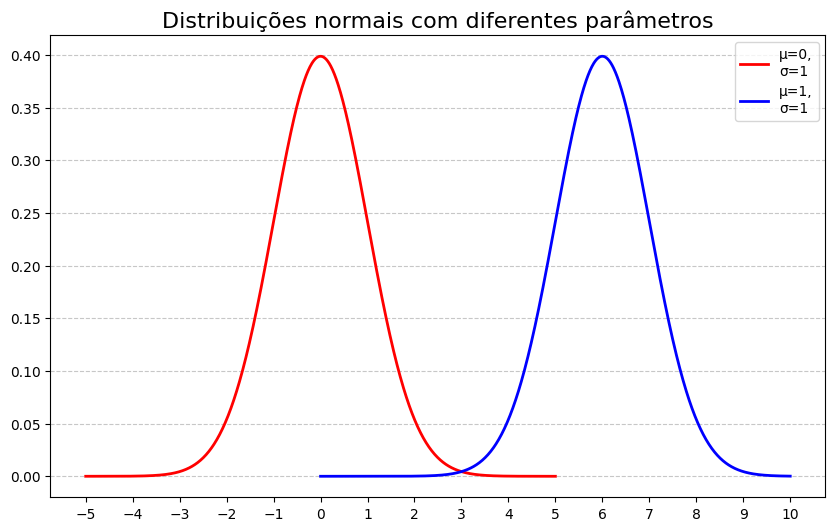

In [22]:
fig_d, ax_d = plt.subplots(figsize=(10, 6))

mu1, sigma1 = 0, 1
mu2, sigma2 = 1, 1

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(0, 10, 1000)

pdf1 = norm.pdf(x1, mu1, sigma1)
pdf2 = norm.pdf(x1, mu2, sigma2)

ax_d.plot(x1, pdf1, 'r-', linewidth=2, label=f"μ={mu1},\nσ={sigma1}")
ax_d.plot(x2, pdf2, 'b-', linewidth=2, label=f"μ={mu2},\nσ={sigma2}")

ax_d.grid(axis='y', linestyle='--', alpha=0.7)

ax_d.set_xticks(np.arange(-5, 11, 1))

ax_d.set_title("Distribuições normais com diferentes parâmetros", fontsize=16)

ax_d.legend(loc='upper right', fontsize=10)

fig_d.show()

# 4.2. Sampling distribution

A partir da distribuição 2, é possível realizar o _sampling_ de 100 amostras de tamanho 3 cada.

In [23]:
sampling = np.random.normal(mu2, sigma2, (100, 3))
sampling

array([[ 2.89549200e-01,  1.23187426e+00,  9.29731418e-01],
       [ 3.22991845e+00,  2.71470118e-01,  1.82248373e-01],
       [ 1.98181872e+00, -8.11908293e-01, -1.76957664e-01],
       [ 8.64943218e-01,  1.73399659e+00,  1.71917070e+00],
       [ 1.20300186e+00, -2.64654437e-01,  1.55919664e+00],
       [ 1.82569616e+00,  1.08431269e+00,  2.56449437e+00],
       [ 9.79426369e-01,  2.18279721e+00,  1.29905554e+00],
       [ 4.78497789e-01, -6.21253197e-01,  2.84790220e+00],
       [ 7.18059685e-01, -1.31381612e+00,  1.27001251e+00],
       [ 1.48124083e+00,  1.74149743e+00,  7.27734780e-01],
       [-4.05685419e-01,  2.12596143e+00, -1.65382934e-01],
       [ 2.23942419e+00, -1.44421800e+00,  8.59376406e-01],
       [ 1.68571125e+00,  1.18745861e+00, -3.19661075e-01],
       [ 1.28366270e+00,  2.67524651e-01,  1.03870166e+00],
       [ 1.60400091e+00,  1.20928505e-01,  6.57965961e-01],
       [-4.52879553e-01, -3.38685028e-01,  9.37757050e-01],
       [ 7.55484681e-01,  6.04078005e-01

## 4.3. p-values

Para calcular o p-value de uma distribuição que se conhece o desvio padrão, utilizamos o z-score, implementado na função `zscore()` e que calcula a seguinte medida:

$$z = \frac{\overline{x} - \mu}{\frac{s}{\sqrt{n}}}$$

Onde:

- $\overline{x}$ é a média das amostras, uma estimativa da população;
- $\mu$ é a média da população, o valor real da média;
- $s$: é o desvio padrão das amostras;
- $n$ é a quantidade de amostras.

In [24]:
def zscore(sample_mean, population_mean, population_stdev, n):
    return (sample_mean - population_mean) / (population_stdev / math.sqrt(n))

Com estas informações, é possível calcular o p-value para cada uma das amostras. Um dicionário `data_pvalues` vai armazenar os valores dos arrays de amostras, das médias das amostras, dos zscores e dos pvalues encontrados. Ao iterar sobre cada amostra, calculamos os parâmetros de `zscore()` e encontramos o valor de `z`, que é então passado para o cálculo do _two-tailed_ p-value, garantindo assim o teste em ambas as caudas da distribuição, considerando apenas os valores à esquerda da seta vermelha da imagem. O dicionário é então utilizado para criar o Datarame `df_pvalues`, usado nas análises de taxa de falsos negativos.

In [25]:
data_pvalues = {
    "sample": [],
    "sample_mean": [],
    "zscore": [],
    "pvalue": []
}

for sample in sampling:
    sample_mean = sample.mean()
    z = zscore(sample_mean, mu2, sigma2, len(sample))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

    data_pvalues["sample"].append(sample)
    data_pvalues["sample_mean"].append(sample_mean)
    data_pvalues["zscore"].append(z)
    data_pvalues["pvalue"].append(p_value)

df_pvalues = pd.DataFrame(data_pvalues)
df_pvalues

,sample,sample_mean,zscore,pvalue
0,"[0.28954919997712014, 1.2318742588401372, 0.92...",0.817052,-0.316876,0.751338
1,"[3.229918452280797, 0.27147011807967625, 0.182...",1.227879,0.394698,0.693066
2,"[1.981818718450489, -0.8119082928551633, -0.17...",0.330984,-1.158769,0.246550
3,"[0.8649432184103982, 1.7339965921499894, 1.719...",1.439370,0.761011,0.446650
4,"[1.203001861068206, -0.26465443737699235, 1.55...",0.832515,-0.290093,0.771745
...,...,...,...,...
95,"[2.3348335620231797, 0.872152343112619, -0.850...",0.785336,-0.371808,0.710036
96,"[-0.1958864072058908, 1.8030061723775594, 1.08...",0.896099,-0.179962,0.857183
97,"[1.5178542892924318, 1.0234714999906276, 1.003...",1.181669,0.314660,0.753020
98,"[0.9881051571380983, -1.4503288562765793, 0.48...",0.008502,-1.717325,0.085920


Ao filtrar o `df_pvalues` para manter apenas as linhas com p-value superior a 0.05, é possível notar que quase todas amostras que não rejeitaram a hipótese nula. Isso significa que, em boa parte das amostras, o teste estatístico concluiu incorretamente que os dados vieram da distribuição vermelha, quando na verdade eles foram gerados pela azul.

In [26]:
df_pvalues_fn = df_pvalues[df_pvalues["pvalue"] > 0.05]
df_pvalues_fn

,sample,sample_mean,zscore,pvalue
0,"[0.28954919997712014, 1.2318742588401372, 0.92...",0.817052,-0.316876,0.751338
1,"[3.229918452280797, 0.27147011807967625, 0.182...",1.227879,0.394698,0.693066
2,"[1.981818718450489, -0.8119082928551633, -0.17...",0.330984,-1.158769,0.246550
3,"[0.8649432184103982, 1.7339965921499894, 1.719...",1.439370,0.761011,0.446650
4,"[1.203001861068206, -0.26465443737699235, 1.55...",0.832515,-0.290093,0.771745
...,...,...,...,...
95,"[2.3348335620231797, 0.872152343112619, -0.850...",0.785336,-0.371808,0.710036
96,"[-0.1958864072058908, 1.8030061723775594, 1.08...",0.896099,-0.179962,0.857183
97,"[1.5178542892924318, 1.0234714999906276, 1.003...",1.181669,0.314660,0.753020
98,"[0.9881051571380983, -1.4503288562765793, 0.48...",0.008502,-1.717325,0.085920


A taxa de falsos negativos é a razão entre a quantidade de FPs em relação ao total de amostras, chegando a cerca de 100%. Essa alta taxa de falsos negativos indica que, com amostras pequenas, o teste tem dificuldades para encontrar diferenças reais entre as distribuições.

In [27]:
rate_fn = len(df_pvalues_fn) / len(df_pvalues)
rate_fn

0.98